In [24]:
import pandas as pd
import numpy as np

#Take off display limitations on Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

oil = pd.read_csv('oil.csv')

In [25]:
oil['time'] = np.arange(len(oil.index))
oil.head()

,date,dcoilwtico,time
0,2013-01-01,NaN,0
1,2013-01-02,93.14,1
2,2013-01-03,92.97,2
3,2013-01-04,93.12,3
4,2013-01-07,93.20,4


In [26]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
 2   time        1218 non-null   int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 23.9+ KB


In [27]:
new_oil = oil.dropna(subset=['dcoilwtico'])

In [28]:
new_oil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1175 entries, 1 to 1217
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1175 non-null   object 
 1   dcoilwtico  1175 non-null   float64
 2   time        1175 non-null   int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 32.1+ KB


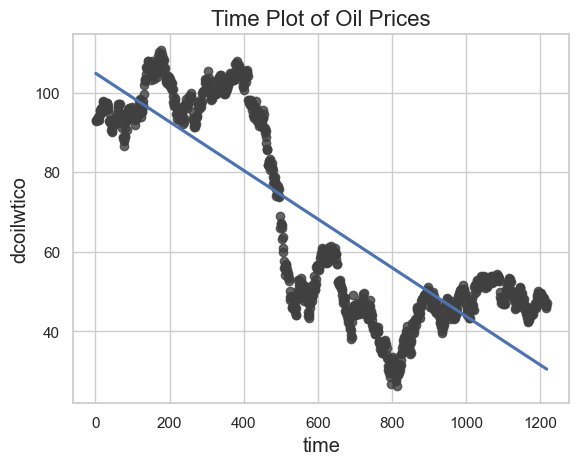

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame called 'oil' with 'Date' and 'dcoilwtico' columns
# Replace this with your actual data

# Set up the plotting style and parameters using Seaborn
sns.set(style="whitegrid")
sns.set_context("notebook", rc={"figure.autolayout": True, "figure.figsize": (11, 4),
                                "axes.labelweight": "bold", "axes.labelsize": "large",
                                "axes.titleweight": "bold", "axes.titlesize": 16, "axes.titlepad": 10})

# Create a figure and axis
fig, ax = plt.subplots()

# Assuming you have a DataFrame called 'oil' with 'Date' and 'dcoilwtico' columns
# Replace 'oil' with your actual DataFrame name
sns.regplot(x='time', y='dcoilwtico', data=new_oil, ci=None, scatter_kws=dict(color='0.25'), ax=ax)

# Set the title
ax.set_title('Time Plot of Oil Prices')

# Show the plot
plt.show()

In [30]:
oil['lag_1'] = oil['dcoilwtico'].shift(1)
lag_oil = oil.reindex(columns=['dcoilwtico', 'lag_1'])

#lag_oil.head()
lag_oil.describe()

,dcoilwtico,lag_1
count,1175.000000,1174.000000
mean,67.714366,67.731789
std,25.630476,25.634437
min,26.190000,26.190000
25%,46.405000,46.402500
50%,53.190000,53.190000
75%,95.660000,95.685000
max,110.620000,110.620000


In [31]:
new_lag_oil = oil.dropna(subset=['dcoilwtico', 'lag_1'])

In [32]:
new_lag_oil.info()
new_lag_oil.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1133 entries, 2 to 1217
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1133 non-null   object 
 1   dcoilwtico  1133 non-null   float64
 2   time        1133 non-null   int32  
 3   lag_1       1133 non-null   float64
dtypes: float64(2), int32(1), object(1)
memory usage: 39.8+ KB


,date,dcoilwtico,time,lag_1
2,2013-01-03,92.97,2,93.14
3,2013-01-04,93.12,3,92.97
4,2013-01-07,93.20,4,93.12
5,2013-01-08,93.21,5,93.20
6,2013-01-09,93.08,6,93.21


Text(0.5, 1.0, 'Lag Plot of Oil prices')

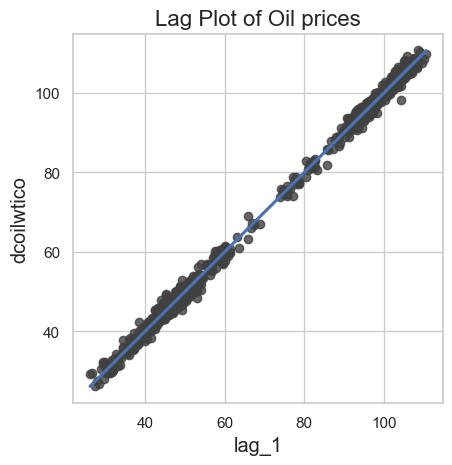

In [33]:
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='dcoilwtico', data=new_lag_oil, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Oil prices')

In [34]:
#Oil conclusion: the lag feature is directly correlated with the original
##oil prices do indeed depend heavily on the previous time step.
##We can also see that the oil prices do not move too much and we can use either Time or Lag shift to train a model to predict values.

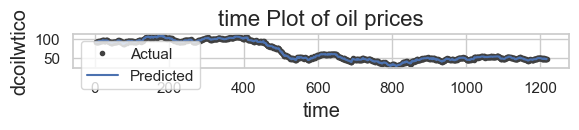

In [35]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Extracting features (X) and target (y)
X = new_lag_oil[['time']]
y = new_lag_oil['dcoilwtico']

# Aligning X and y based on their common index
y, X = y.align(X, join='inner')

# Creating an XGBoost regressor
model_oil = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Fitting the model
model_oil.fit(X, y)

# Making predictions
y_pred = pd.Series(model_oil.predict(X), index=X.index)

# Creating a lag plot
fig, ax = plt.subplots()
ax.plot(X['time'], y, '.', color='0.25', label='Actual')
ax.plot(X['time'], y_pred, label='Predicted')
ax.set_aspect('equal')
ax.set_ylabel('dcoilwtico')
ax.set_xlabel('time')
ax.set_title('time Plot of oil prices')
ax.legend()
plt.show()

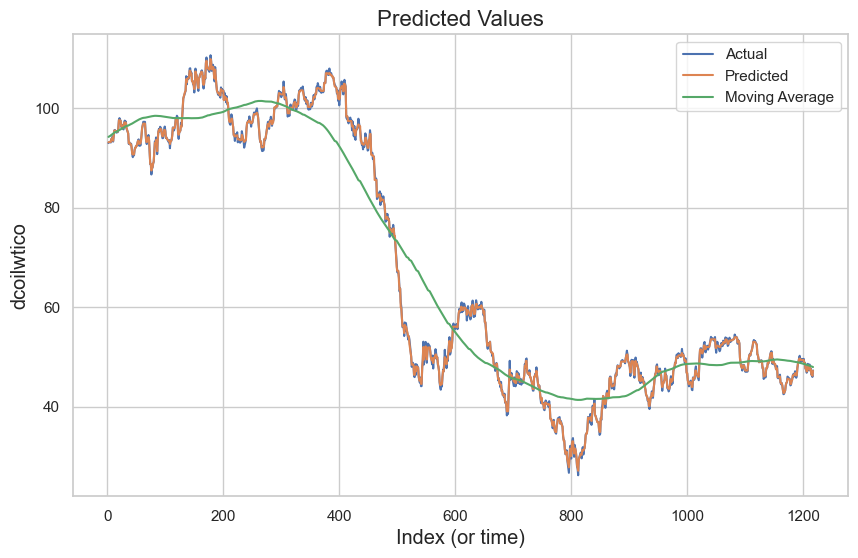

In [36]:
import matplotlib.pyplot as plt

# Set your plot parameters as needed
plot_params = {
    'figsize': (10, 6),  # Figure size
    'title': 'Predicted Values',  # Title
    'xlabel': 'Index (or time)',  # X-axis label
    'ylabel': 'dcoilwtico',  # Y-axis label
}

moving_average = y_pred.rolling(
    window=242,       # 242-day window
    center=True,      # puts the average at the center of the window
    min_periods=121,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

# Create a plot
ax = y.plot(**plot_params, label='Actual')  # Plot actual values
y_pred.plot(ax=ax, label='Predicted')  # Plot predicted values on the same axis
moving_average.plot(ax=ax, label='Moving Average')  # Plot the moving average on the same axis


# Add a legend
ax.legend()

# Display the plot
plt.show()
